# Spark

This tutorial will show you how to get a Spark instance up and running locally to integrate with JupySQL. You can run this in a Jupyter notebook. We'll use [Spark Connect](https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_connect.html) which is the new thin client for Spark

## Pre-requisites

To run this tutorial, you need to install following Python packages:

In [26]:
%pip install jupysql pyspark==3.4.1 arrow pyarrow==12.0.1 pandas grpc-status --quiet

Note: you may need to restart the kernel to use updated packages.


## Start Spark instance

We fetch the official image, create a new database, and user (this will take a few seconds).

In [26]:
%%bash
docker run -p 15002:15002 -p 4040:4040 -d --name spark wh1isper/sparglim-server

8e3831298eb9dce9d26b2f2d3df5a1a64634a19976f4eaeabf92c45afd478a39


Our database is running, let's load some data!

## Load sample data

Now, let's fetch some sample data. We'll be using the [NYC taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page):

In [27]:
import pandas as pd
from pyspark.sql.connect.session import SparkSession

spark = SparkSession.builder.remote("sc://localhost").getOrCreate()

df = pd.read_parquet(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"
)
sparkDf = spark.createDataFrame(df.head(10000))

Set [eagerEval](https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html#Viewing-Data) on to print dataframes, This makes Spark print dataframes eagerly in notebook environments, rather than it's default lazy execution which requires .show() to see the data. In Spark 3.4.1 we need to override, as below, but in 3.5.0 it will print in html. 

In [28]:
def __pretty_(self, p, cycle):
    self.show(truncate=False)


from pyspark.sql.connect.dataframe import DataFrame

DataFrame._repr_pretty_ = __pretty_
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

Add dataset to temporary view to allow querying:

In [29]:
sparkDf.createOrReplaceTempView("taxi")

## Query

Now, let's start JupySQL, authenticate, and query the data!

In [30]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [31]:
%sql spark

```{important}
If the cell above fails, you might have some missing packages. Message us on [Slack](https://ploomber.io/community) and we'll help you!
```

List the tables in the database:

In [46]:
%sqlcmd tables

NotImplementedError: This feature is only available for SQLAlchemy connections

List columns in the taxi table:

In [33]:
df = %sql select * from taxi
df.printSchema()

Running query in 'SparkSession'

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



Query our data:

In [34]:
%%sql
SELECT COUNT(*) FROM taxi

Running query in 'SparkSession'

+--------+
|count(1)|
+--------+
|10000   |
+--------+



## Parameterize queries

In [35]:
threshold = 10

In [36]:
%%sql
SELECT COUNT(*) FROM taxi
WHERE trip_distance < {{threshold}}

Running query in 'SparkSession'

+--------+
|count(1)|
+--------+
|9476    |
+--------+



In [37]:
threshold = 0.5

In [38]:
%%sql
SELECT COUNT(*) FROM taxi
WHERE trip_distance < {{threshold}}

Running query in 'SparkSession'

+--------+
|count(1)|
+--------+
|642     |
+--------+



## CTEs

In [39]:
%%sql --save many_passengers --no-execute
SELECT *
FROM taxi
WHERE passenger_count > 3
-- remove top 1% outliers for better visualization
AND trip_distance < 18.93

Running query in 'SparkSession'

Skipping execution...

In [40]:
%%sql --save trip_stats --with many_passengers
SELECT MIN(trip_distance), AVG(trip_distance), MAX(trip_distance)
FROM many_passengers

Running query in 'SparkSession'

+------------------+------------------+------------------+
|min(trip_distance)|avg(trip_distance)|max(trip_distance)|
+------------------+------------------+------------------+
|0.0               |3.1091381872213963|18.46             |
+------------------+------------------+------------------+



This is what JupySQL executes:

In [41]:
query = %sqlcmd snippets trip_stats
print(query)

WITH `many_passengers` AS (
SELECT *
FROM taxi
WHERE passenger_count > 3

AND trip_distance < 18.93)
SELECT MIN(trip_distance), AVG(trip_distance), MAX(trip_distance)
FROM many_passengers


## Plotting

The %sqlplot magic command currently supported by the spark connection but you can still plot as like this:

Running query in 'SparkSession'

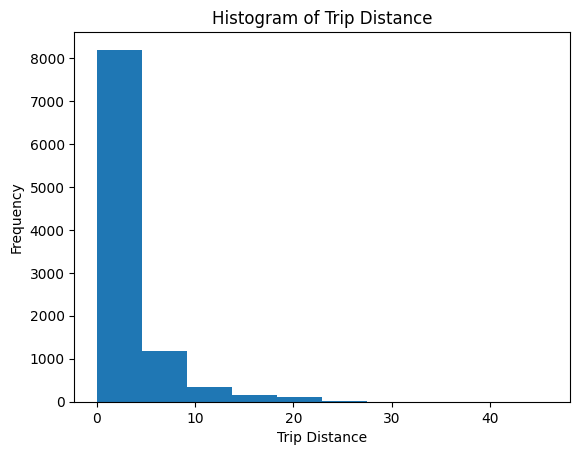

In [45]:
result = %sql SELECT trip_distance FROM taxi

import matplotlib.pyplot as plt

data = result.toPandas()

plt.hist(data["trip_distance"])
plt.xlabel("Trip Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Trip Distance")
plt.show()

Running query in 'SparkSession'

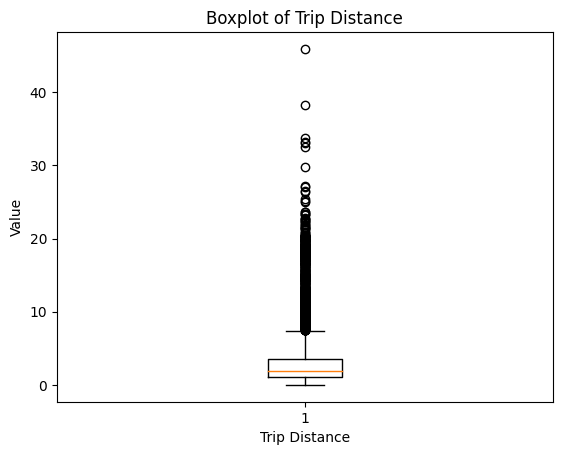

In [20]:
result = %sql SELECT trip_distance FROM taxi

import matplotlib.pyplot as plt

data = result.toPandas()

plt.boxplot(data["trip_distance"])
plt.xlabel("Trip Distance")
plt.ylabel("Value")
plt.title("Boxplot of Trip Distance")
plt.show()

## Clean up

To stop and remove the container:

In [21]:
! docker container ls

CONTAINER ID   IMAGE                                                      COMMAND                  CREATED         STATUS         PORTS                                              NAMES
4a7133e0b70b   wh1isper/sparglim-server                                   "tini -- sparglim-se…"   4 minutes ago   Up 4 minutes   0.0.0.0:4040->4040/tcp, 0.0.0.0:15002->15002/tcp   spark
f019407c6426   docker.dev.slicelife.com/onelogin-aws-assume-role:stable   "onelogin-aws-assume…"   2 weeks ago     Up 2 weeks                                                        heuristic_tu


In [22]:
%%capture out
! docker container ls --filter ancestor=wh1isper/sparglim-server --quiet

In [23]:
container_id = out.stdout.strip()
print(f"Container id: {container_id}")

Container id: 4a7133e0b70b


In [24]:
! docker container stop {container_id}

4a7133e0b70b


In [25]:
! docker container rm {container_id}

4a7133e0b70b
